<a href="https://colab.research.google.com/github/xiangyu066/DL-FlaNet/blob/master/FlaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!/opt/bin/nvidia-smi

Wed Nov  6 09:02:44 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# **Acess to Google drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Importing datasets**

In [3]:
cd /content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/trainingImages_npy/

/content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/trainingImages_npy


In [0]:
import numpy as np

trainingImages = []
trainingLabels = []

trainingImages_Flagellated = np.load('Flagellated_images.npy')
trainingImages = trainingImages_Flagellated
trainingLabels_Flagellated = np.load('Flagellated_labels_hot.npy')
trainingLabels = trainingLabels_Flagellated

trainingImages_nonFlagellated = np.load('nonFlagellated_images.npy')
trainingImages = np.append(trainingImages,trainingImages_nonFlagellated,axis=0)
trainLabels_nonFlagellated = np.load('nonFlagellated_labels_hot.npy')
trainingLabels = np.append(trainingLabels,trainLabels_nonFlagellated,axis=0)

#trainingImages = trainingImages.astype('float32') / 255

In [0]:
# manual shuffle
idx = np.random.permutation(len(trainingLabels))
trainingLabels=trainingLabels[idx]
trainingImages=trainingImages[idx,]

In [6]:
trainingLabels.shape

(9536,)

In [7]:
trainingImages.shape

(9536, 128, 128, 1)

In [8]:
cd /content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/testImages_npy/

/content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/testImages_npy


In [0]:
testImages = []
testLabels = []

testImages_Flagellated = np.load('Flagellated_images.npy')
testImages = testImages_Flagellated
testLabels_Flagellated = np.load('Flagellated_labels_hot.npy')
testLabels = testLabels_Flagellated

testImages_nonFlagellated = np.load('nonFlagellated_images.npy')
testImages = np.append(testImages,testImages_nonFlagellated,axis=0)
testLabels_nonFlagellated = np.load('nonFlagellated_labels_hot.npy')
testLabels = np.append(testLabels,testLabels_nonFlagellated,axis=0)

#testImages = testImages.astype('float32') / 255

In [10]:
testLabels.shape

(2384,)

In [11]:
testImages.shape

(2384, 128, 128, 1)

# **Training a neural network**

In [12]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

In [13]:
from keras import layers
from keras import models
from keras import regularizers

FlaNet = models.Sequential()
FlaNet.add(layers.Conv2D(64, (5, 5), activation='relu', input_shape=(128, 128, 1), padding='same'))
FlaNet.add(layers.MaxPooling2D((3, 3),strides=2))
FlaNet.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
FlaNet.add(layers.MaxPooling2D((3, 3),strides=2))
FlaNet.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))
FlaNet.add(layers.MaxPooling2D((3, 3),strides=2))
FlaNet.add(layers.Flatten())
FlaNet.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
FlaNet.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))

# binary crossentropy
FlaNet.add(layers.Dense(1, activation='sigmoid')) 

# categorical crossentropy
#FlaNet.add(layers.Dense(2, activation='softmax')) 

FlaNet.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 31, 128)       409728    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)        

In [14]:
from keras import optimizers

# binary crossentropy
FlaNet.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# categorical crossentropy
#from keras.utils import to_categorical
#trainingLabels = to_categorical(trainingLabels)
#testLabels = to_categorical(testLabels)
#FlaNet.compile(optimizer=optimizers.RMSprop(lr=1e-5),
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
history = FlaNet.fit(trainingImages, trainingLabels, epochs=100, batch_size=16, validation_split=0.2)




Train on 7628 samples, validate on 1908 samples
Epoch 1/100





7628/7628 [==============================] - 34s 5ms/step - loss: 5.5463 - acc: 0.5214 - val_loss: 0.4963 - val_acc: 0.8139
Epoch 2/100
7628/7628 [==============================] - 26s 3ms/step - loss: 0.4177 - acc: 0.8662 - val_loss: 0.2822 - val_acc: 0.9099
Epoch 3/100
7628/7628 [==============================] - 27s 3ms/step - loss: 0.2409 - acc: 0.9249 - val_loss: 0.1758 - val_acc: 0.9528
Epoch 4/100
7628/7628 [==============================] - 26s 3ms/step - loss: 0.1735 - acc: 0.9525 - val_loss: 0.1629 - val_acc: 0.9549
Epoch 5/100
7628/7628 [==============================] - 26s 3ms/step - loss: 0.1428 - acc: 0.9647 - val_loss: 0.1747 - val_acc: 0.9471
Epoch 6/100
7628/7628 [==============================] - 26s 3ms/step - loss: 0.1219 - acc: 0.9716 - val_loss: 0.1322 - val_acc: 0.9638
Epoch 7/100
7628/7628 [==============================] - 26s 3ms/step - loss: 0.1105 - acc: 0.9746 - val_loss: 0.1727 - val_acc:

In [16]:
test_loss, test_acc = FlaNet.evaluate(testImages, testLabels)
test_acc

2384/2384 [==============================] - 3s 1ms/step


0.9907718120805369

In [17]:
test_loss

0.06341471308186

# **Confusion matrix**

In [0]:
test_predict = FlaNet.predict(testImages)
##
# binary crossentropy
predictLabels = [1 * (test_predict[i]>=0.5) for i in range(len(test_predict))]
predictLabels = np.array(predictLabels)

# categorical crossentropy
#predictLabels = np.array([np.argmax(test_predict[i]) for i in range(len(test_predict))])
#testLabels = np.array([np.argmax(testLabels[i]) for i in range(len(test_predict))])

In [19]:
predictLabels.shape

(2384, 1)

In [20]:
testLabels.shape

(2384,)

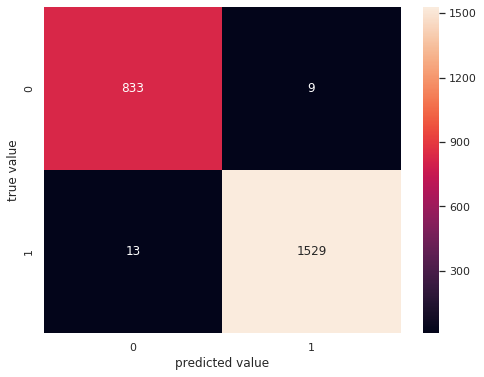

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix

mat = confusion_matrix(predictLabels, testLabels)

plt.figure(figsize=(8,6))
ax=sns.heatmap(mat, square=False, annot=True, fmt="d", cbar=True)

# There is a bug in matplotlib 3.1.1 causing truncated heatmap 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('predicted value')
plt.ylabel('true value')

plt.show()

# **Inspection of overfitting**

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

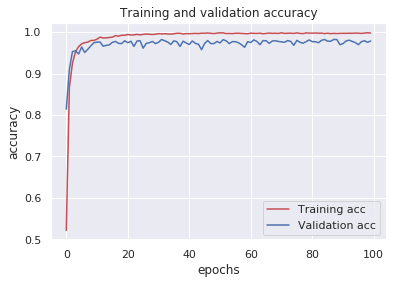

In [23]:
plt.figure()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

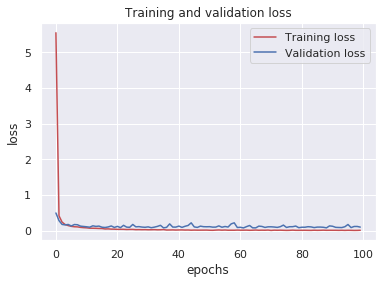

In [24]:
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

#**Save trained network & history**

In [25]:
cd /content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets/

/content/gdrive/My Drive/Colab Notebooks/FlaNet/trainingDatasets


In [0]:
# save trained network
FlaNet.save('FlaNet.h5') 

In [0]:
# save history
import pandas as pd
   
FlaNet_df = pd.DataFrame(history.history) 

with open('FlaNet.csv', mode='w') as f:
    FlaNet_df.to_csv(f)